In [1]:
import os
import time
import copy
import math
import pickle
import roadrunner
import numpy as np
import pocomc as pc
from scipy.stats import qmc
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
SEED=1
np.random.seed(seed=SEED)
n_cpus = os.cpu_count() 

# Model system parameters
MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
DURATION = 20000
SPECIES_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

# Synthetic dataset parameters
PCT_NOISE = 0.01 # % Gaussian noise (range is 0-1)
N_PTS = 20

N_PARTICLES = 1000

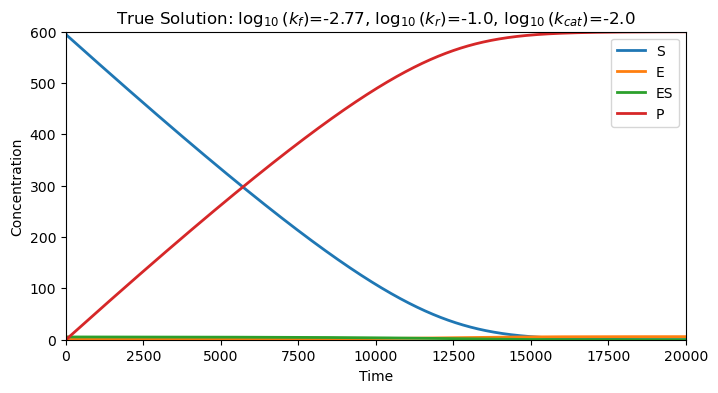

In [3]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8

TRUE_VALS = [rr[PARAMS[0]],rr[PARAMS[1]],rr[PARAMS[2]]]

plt.figure(figsize=(8,4), dpi=100)
res = rr.simulate(0, DURATION, DURATION*10)
ts = res[:, 0]
trajs = np.transpose(res[:, 1:])

for label, color, traj in zip(SPECIES, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)
plt.legend(); plt.margins(x=0, y=0)
plt.xlabel('Time'); plt.ylabel('Concentration');
title = "True Solution: $\log_{{10}}(k_f)$={k1}, $\log_{{10}}(k_r)$={k2}, $\log_{{10}}(k_{{cat}})$={k3}".format(k1=rr[PARAMS[0]], k2=rr[PARAMS[1]], k3=rr[PARAMS[2]])
plt.title(title);

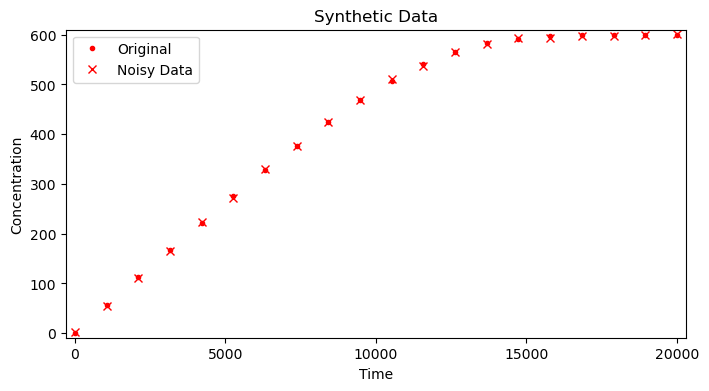

In [4]:
def gaussian_noise(x,std, mu=0):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy

rr.resetAll()
res = rr.simulate(0, DURATION, N_PTS)
ts_data = res[:, 0]
prod_traj = res[:, -1]

std = PCT_NOISE * np.std(prod_traj)
noisy_data = gaussian_noise(prod_traj, std)

# Plot noisy data
plt.figure(figsize=(8,4), dpi=100)
plt.plot(ts_data, prod_traj, 'r.', label="Original")
plt.plot(ts_data, noisy_data, 'rx', label="Noisy Data")
plt.legend(); plt.margins(x=0.015, y=0.015)
plt.xticks([0, 0.5*1e4, 1e4,1.5*1e4, 2*1e4])
plt.xlabel('Time'); plt.ylabel('Concentration');
plt.title('Synthetic Data'); #plt.xscale("log");

In [15]:
def change_and_run(new_params):
    rr.resetAll()
    for name,val in zip(PARAMS, new_params):
        rr[name] = float(val)
        rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
        #print(name, val, rr[name])
    try:
        res = rr.simulate(0, DURATION, 1000*N_PTS)
        #print(res)
    except:
        res = []
    return np.asarray(res)

def cost_fun(params):
    candidate_params = copy.deepcopy(params)    
    res_guess = change_and_run(candidate_params)

    if np.isnan(res_guess).any() or not np.any(res_guess):
        return np.inf
    
    ts_guess = res_guess[:, 0]
    p_guess = res_guess[:, -1] # product 

    #print(ts_data, '\n', ts_guess[:10])
    t_idxs = np.array([i for i in range(len(ts_guess)) for j in range(len(ts_data)) if math.isclose(ts_guess[i],ts_data[j])])
    
    if t_idxs.shape[0] != ts_data.shape[0]:
        print(t_idxs.shape[0], ts_data.shape[0])
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    
    p_guess_short = p_guess[t_idxs]
    # need to cast square difference as a numpy array otherwise the returned sse will be returned as a librr object which causes issues when saving in h5 file via pypesto
    sse = np.sum(np.asarray(np.square(noisy_data - p_guess_short)))
    return -1*sse

def log_prior(theta_new):
    bnds = np.log10([(1e-3, 1e1), (1e-1, 1e3), (1e-3, 1e3)])
    lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds]; 
    bools = [(low <= i <= high) for i,low,high in zip(theta_new, lb, ub)] #if generated values are within bounds
    all_in_range = np.all(bools) #if all values are true, then output is true
    if all_in_range: #if true
        return 0.0 #give 0
    return -np.inf

In [6]:
bnds = np.log10([(1e-3, 1e1), (1e-1, 1e3), (1e-3, 1e3)])
lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds];

# Initialise particles' positions using samples from the prior (this is very important, other initialisation will not work).
sampler = qmc.LatinHypercube(d=len(PARAMS), seed=SEED) #d is amount of parameters being solved for in model 2
sample = sampler.random(n=N_PARTICLES) #causes sample to be an array of n_particles x mod2.theta_n (1000x3)  
prior_samples = qmc.scale(sample, l_bounds=lb, u_bounds=ub) #widens/narrows sample to be within the bounds given

In [ ]:
# Pocomc
t0 = time.time() #stores current time, date, year, etc. in one float
with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    sampler = pc.Sampler(n_particles = N_PARTICLES,
                         n_dim = len(PARAMS),
                         log_likelihood = cost_fun,
                         log_prior = log_prior,
                         bounds = bnds,
                         pool = pool,
                         random_state=SEED,
                         infer_vectorization=False,
                         vectorize_likelihood=False)
    sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
    result = sampler.results #results of sampler.run on prior_samples


with open('mm_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds))
print(elapsed)

In [ ]:
print(elapsed)

In [ ]:
pc.plotting.trace(result, labels=PARAMS)

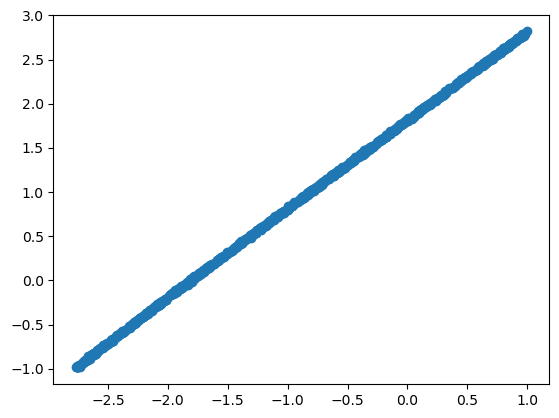

In [7]:
# Load result file
results = {}
with open('mm_result.pkl', "rb") as f:
    results = pickle.load(f)

samples = results["x"]
logw = results["logw"]
beta = results["beta"]

# Compute weights
weights = np.exp(logw - np.max(logw, axis=1)[:, np.newaxis])
weights /= np.sum(weights, axis=1)[:, np.newaxis]

posterior = samples[-1, :, :]
posterior_weights = weights[-1]

plt.scatter(posterior[:, 0], posterior[:, 1])

In [17]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)*100
LOWER_PCT = ((1-CI)/2)*100
samples = results["x"] #(n_iterations x n_particles x n_params)
posterior_pars = samples[-1, :, :] #this will return a 2D matrix of shape (n_particles x n_params) of the last interation
all_trajectories = []

for i, post_par in enumerate(posterior_pars):
    sample_trajectory = change_and_run(post_par)
    product_trajectory = sample_trajectory[:, -1]
    all_trajectories.append(product_trajectory)
all_trajectories = np.array(all_trajectories) 

(1000, 3)


In [18]:
print(all_trajectories.shape)
ts = np.linspace(0, DURATION, 1000*N_PTS)
sim_means = np.mean(all_trajectories, axis=0)
low_ci = np.percentile(all_trajectories, LOWER_PCT, axis=0)
high_ci = np.percentile(all_trajectories, UPPER_PCT, axis=0) 

(1000, 20000)


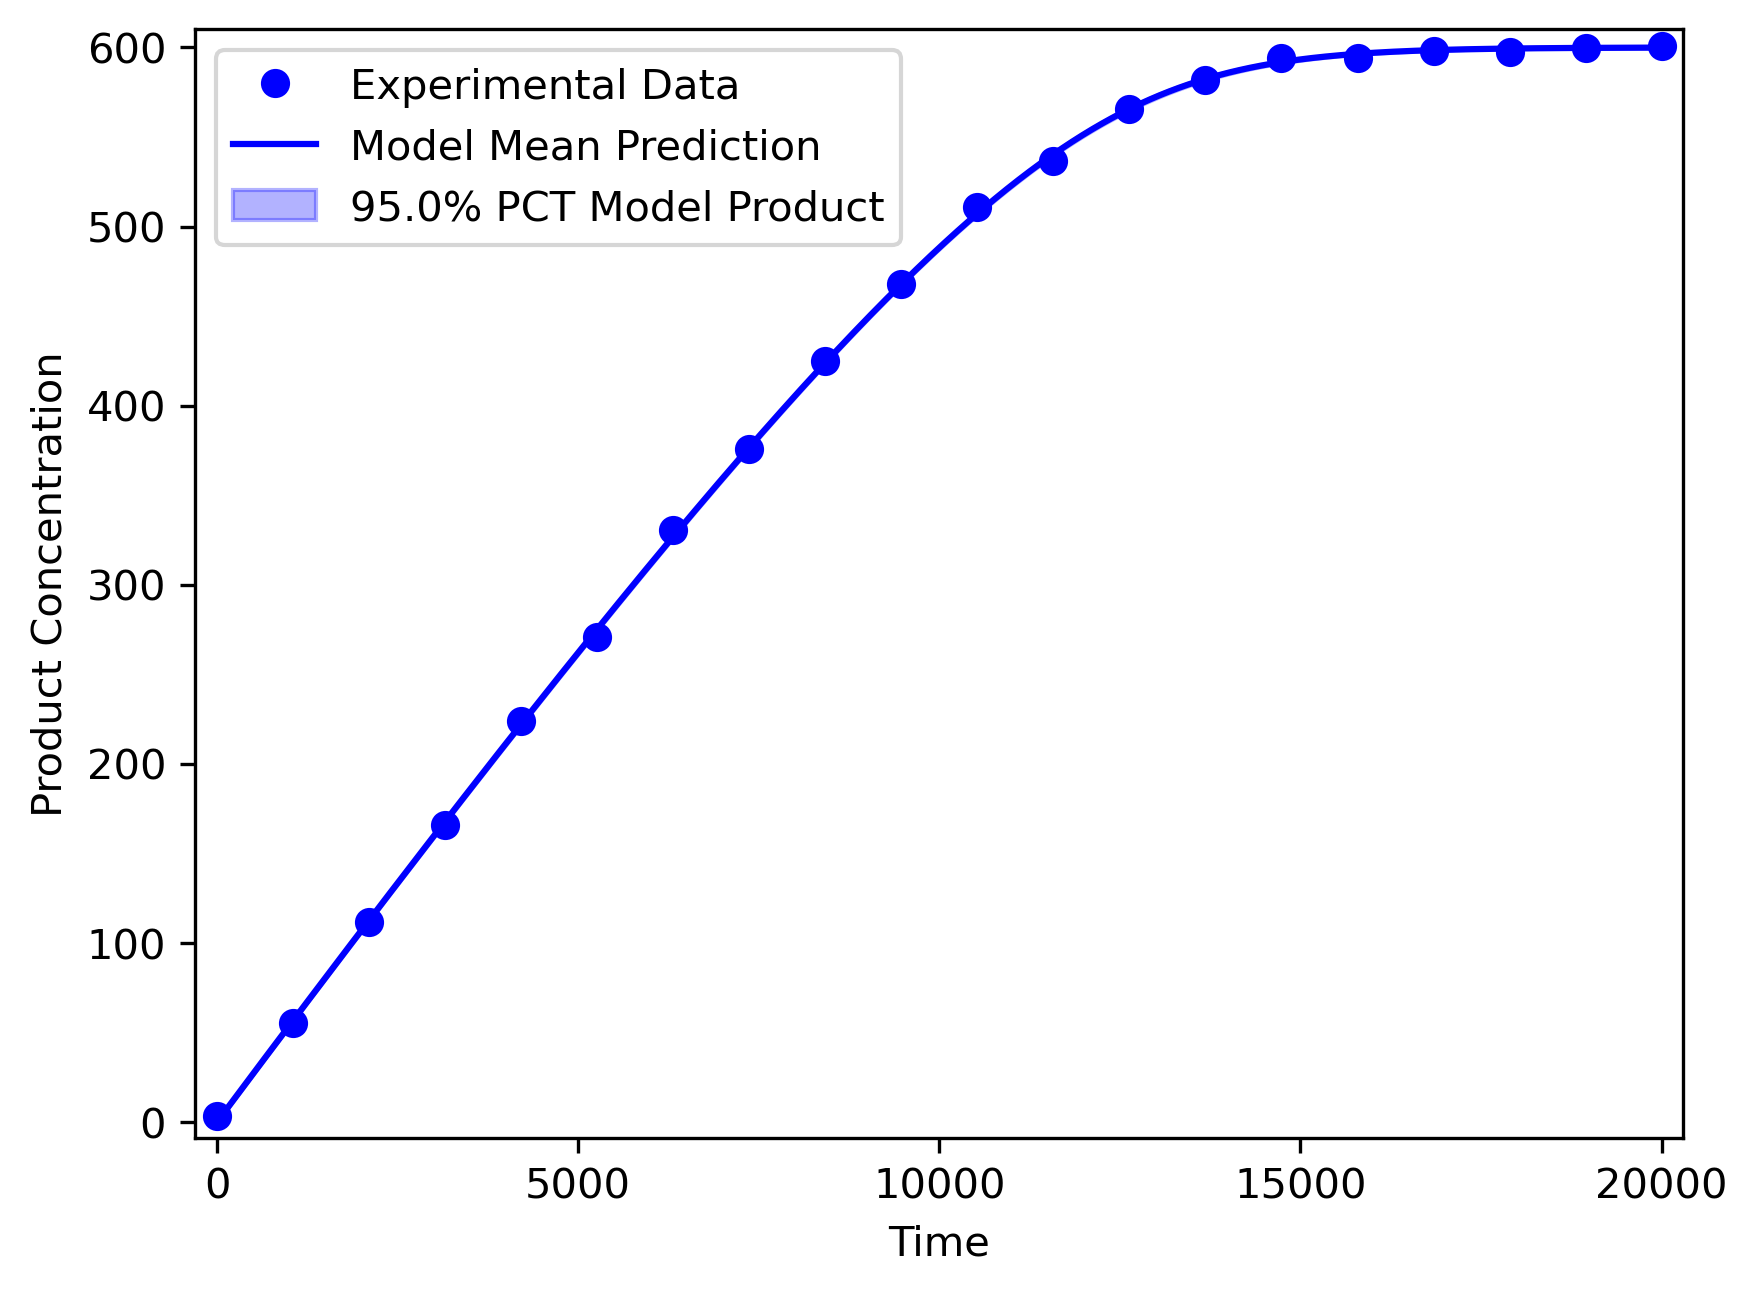

In [21]:
plt.figure(dpi=300)

plt.plot(ts_data, noisy_data, 'bo', label="Experimental Data")

plt.plot(ts, sim_means, "b-", label="Model Mean Prediction")
plt.fill_between(ts, low_ci, high_ci, color='b', 
                 alpha=0.3, label="{}% PCT Model Product".format(CI*100));

plt.legend(); plt.margins(x=0.015, y=0.015)
plt.xticks([0, 0.5*1e4, 1e4,1.5*1e4, 2*1e4])
plt.xlabel('Time'); plt.ylabel('Product Concentration');